In [2]:
# Importing necessary libraries
import pandas as pd

# Reading the CSV file
file_path = "../master_final.csv"
data = pd.read_csv(file_path)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Extracting the hour of the day by splitting the arrival_time_new string
data['hour_of_day'] = data['arrival_time_new'].apply(lambda x: int(x.split()[2].split(':')[0])) 

# Define the features and target variables
selected_features = ['stop_sequence', 'day_of_the_week', 'time_category', 'dist_to_next_stop', 'hour_of_day']
selected_targets = ['next_stop_sequence', 'time_diff']

# Prepare the input and output arrays
X = data[selected_features]
y = data[selected_targets]

# One-hot encode the categorical variables
categorical_features = ['day_of_the_week', 'time_category']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", 
                                  one_hot, 
                                  categorical_features)], 
                                remainder="passthrough")
X_transformed = transformer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Creating the Random Forest regressor
rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))

# Training the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Predicting on the testing set
rf_y_pred = rf_model.predict(X_test)

# Evaluating the Random Forest model using MAE, RMSE, and R² score
rf_mae_next_stop_sequence = mean_absolute_error(y_test['next_stop_sequence'], rf_y_pred[:, 0])
rf_rmse_next_stop_sequence = np.sqrt(mean_squared_error(y_test['next_stop_sequence'], rf_y_pred[:, 0]))
rf_r2_next_stop_sequence = r2_score(y_test['next_stop_sequence'], rf_y_pred[:, 0])

rf_mae_time_diff = mean_absolute_error(y_test['time_diff'], rf_y_pred[:, 1])
rf_rmse_time_diff = np.sqrt(mean_squared_error(y_test['time_diff'], rf_y_pred[:, 1]))
rf_r2_time_diff = r2_score(y_test['time_diff'], rf_y_pred[:, 1])

(rf_mae_next_stop_sequence, rf_rmse_next_stop_sequence, rf_r2_next_stop_sequence), (rf_mae_time_diff, rf_rmse_time_diff, rf_r2_time_diff)

((0.000965237934525814, 0.0268531839142292, 0.9999983711896963),
 (2.956524485390222, 7.627967176869344, 0.9741290049431997))

C:\Users\aggarwpa\AppData\Local\Temp\ipykernel_9808\3926360927.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_single_trip['rf_residuals'] = rf_single_trip['actual_time_diff'] - rf_single_trip['rf_predicted_time_diff']


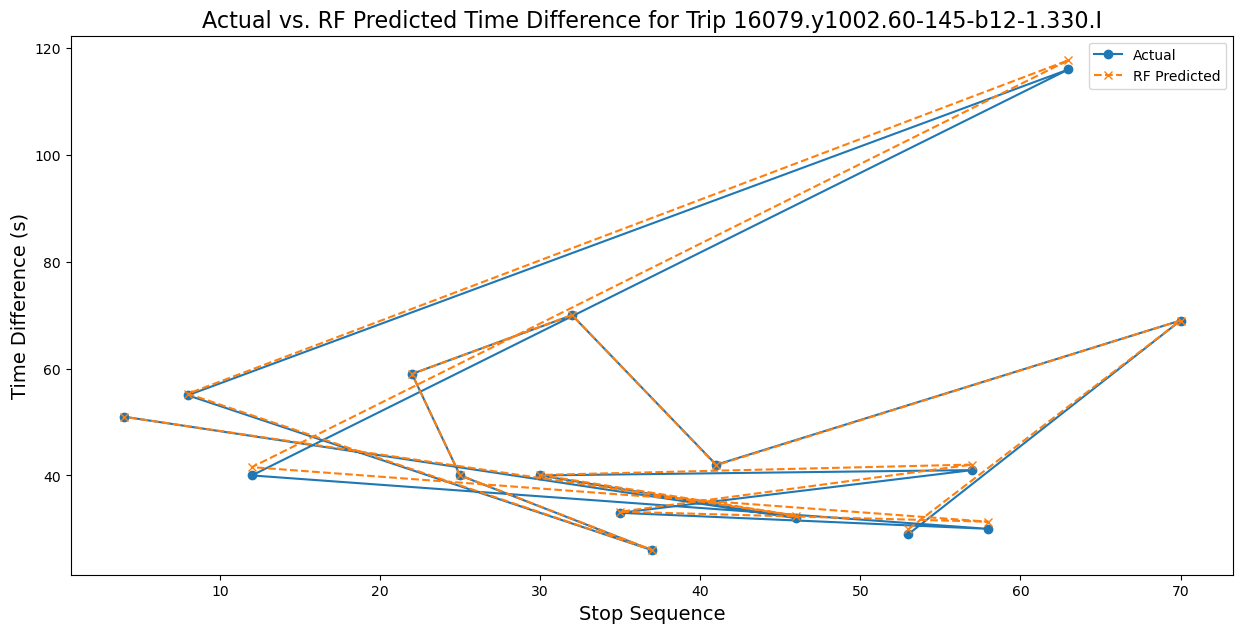

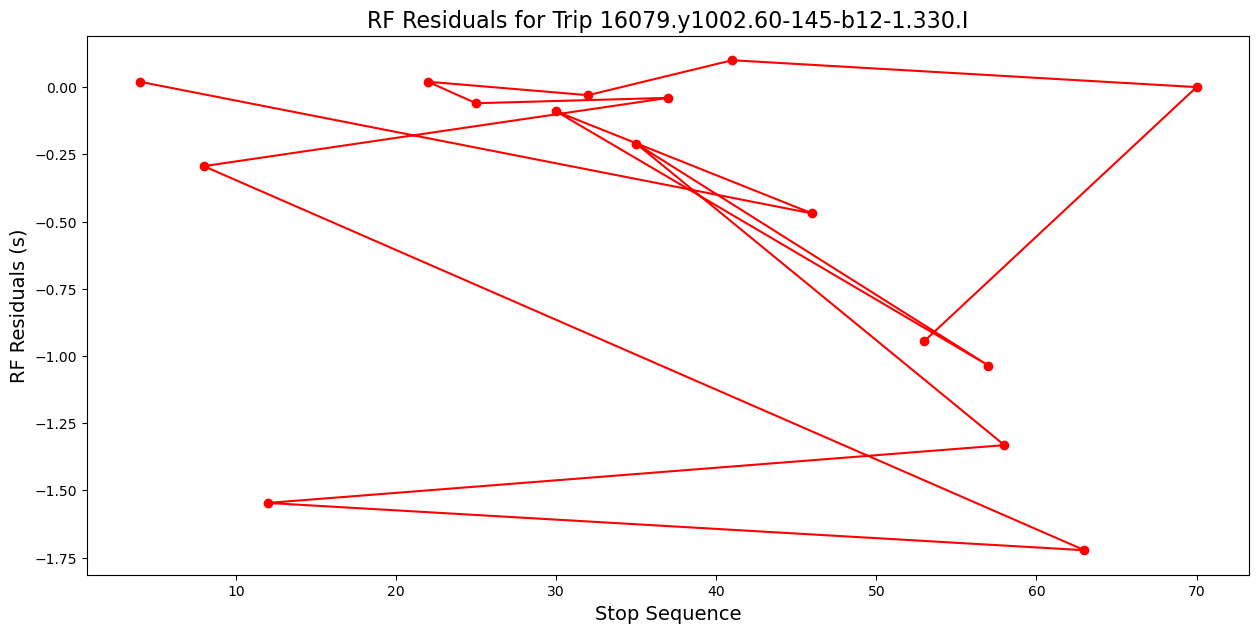

In [6]:
import random
import matplotlib.pyplot as plt

# Convert X_test back to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=transformer.get_feature_names_out(input_features=selected_features))

# Add the actual and predicted time_diff to the DataFrame
X_test_df['actual_time_diff'] = y_test['time_diff'].values

# Add the KNN predicted time_diff to the DataFrame
X_test_df['rf_predicted_time_diff'] = rf_y_pred[:, 1]

# Add the trip_id, stop_sequence columns from the original df_sorted DataFrame
X_test_df['trip_id'] = data.loc[y_test.index, 'trip_id'].values
X_test_df['stop_sequence'] = data.loc[y_test.index, 'stop_sequence'].values

# Select 20 random trips
random_trips = random.sample(X_test_df['trip_id'].unique().tolist(), 20)

# Select one random trip from the previously selected random trips
selected_trip = random.choice(random_trips)

########################

# Filter the DataFrame to include only the selected trip
rf_single_trip = X_test_df[X_test_df['trip_id'] == selected_trip]

# Calculate the residuals for the selected trip
rf_single_trip['rf_residuals'] = rf_single_trip['actual_time_diff'] - rf_single_trip['rf_predicted_time_diff']

# Create a plot of actual vs. KNN predicted time_diff for the selected trip
plt.figure(figsize=(15, 7))
plt.plot(rf_single_trip['stop_sequence'], rf_single_trip['actual_time_diff'], marker='o', label='Actual')
plt.plot(rf_single_trip['stop_sequence'], rf_single_trip['rf_predicted_time_diff'], marker='x', linestyle='dashed', label='RF Predicted')

# Set plot title and labels
plt.title(f'Actual vs. RF Predicted Time Difference for Trip {selected_trip}', fontsize=16)
plt.xlabel('Stop Sequence', fontsize=14)
plt.ylabel('Time Difference (s)', fontsize=14)
plt.legend()

# Show the plot
plt.show()

# Create a plot of KNN residuals for the selected trip
plt.figure(figsize=(15, 7))
plt.plot(rf_single_trip['stop_sequence'], rf_single_trip['rf_residuals'], marker='o', color='red')

# Set plot title and labels
plt.title(f'RF Residuals for Trip {selected_trip}', fontsize=16)
plt.xlabel('Stop Sequence', fontsize=14)
plt.ylabel('RF Residuals (s)', fontsize=14)

# Show the plot
plt.show()

In [7]:
# Creating the Random Forest regressor with the best hyperparameters
optimized_rf_model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=900,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=1,
    random_state=42
))

# Training the optimized Random Forest model on the training data
optimized_rf_model.fit(X_train, y_train)

# Predicting on the testing set
optimized_rf_y_pred = optimized_rf_model.predict(X_test)

# Evaluating the optimized Random Forest model using MAE, RMSE, and R² score
optimized_rf_mae_next_stop_sequence = mean_absolute_error(y_test['next_stop_sequence'], optimized_rf_y_pred[:, 0])
optimized_rf_rmse_next_stop_sequence = np.sqrt(mean_squared_error(y_test['next_stop_sequence'], optimized_rf_y_pred[:, 0]))
optimized_rf_r2_next_stop_sequence = r2_score(y_test['next_stop_sequence'], optimized_rf_y_pred[:, 0])

optimized_rf_mae_time_diff = mean_absolute_error(y_test['time_diff'], optimized_rf_y_pred[:, 1])
optimized_rf_rmse_time_diff = np.sqrt(mean_squared_error(y_test['time_diff'], optimized_rf_y_pred[:, 1]))
optimized_rf_r2_time_diff = r2_score(y_test['time_diff'], optimized_rf_y_pred[:, 1])

print("Next Stop Sequence Metrics:")
print("MAE:", optimized_rf_mae_next_stop_sequence)
print("RMSE:", optimized_rf_rmse_next_stop_sequence)
print("R²:", optimized_rf_r2_next_stop_sequence)

print("\nTime Difference to Next Stop Metrics:")
print("MAE:", optimized_rf_mae_time_diff)
print("RMSE:", optimized_rf_rmse_time_diff)
print("R²:", optimized_rf_r2_time_diff)

Next Stop Sequence Metrics:
MAE: 0.0009813627329658301
RMSE: 0.027096655491175115
R²: 0.999998341519709

Time Difference to Next Stop Metrics:
MAE: 2.9505985808911475
RMSE: 7.632325761090143
R²: 0.974099431369077


In [5]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test['time_diff'], rf_y_pred[:, 1])

6727280442369.877

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate Mean Absolute Percentage Error between y_true and y_pred
    
    :param y_true: the true target values
    :param y_pred: the predicted target values
    :returns: the Mean Absolute Percentage Error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_elements = y_true != 0
    return np.mean(np.abs((y_true[non_zero_elements] - y_pred[non_zero_elements]) / y_true[non_zero_elements])) * 100

# Calculating MAPE for the Next Stop Sequence
optimized_rf_mape_next_stop_sequence = mean_absolute_percentage_error(y_test['next_stop_sequence'], optimized_rf_y_pred[:, 0])

# Calculating MAPE for the Time Difference to Next Stop
optimized_rf_mape_time_diff = mean_absolute_percentage_error(y_test['time_diff'], optimized_rf_y_pred[:, 1])

print("Next Stop Sequence Metrics:")
print("MAE:", optimized_rf_mae_next_stop_sequence)
print("RMSE:", optimized_rf_rmse_next_stop_sequence)
print("R²:", optimized_rf_r2_next_stop_sequence)
print("MAPE:", optimized_rf_mape_next_stop_sequence)

print("\nTime Difference to Next Stop Metrics:")
print("MAE:", optimized_rf_mae_time_diff)
print("RMSE:", optimized_rf_rmse_time_diff)
print("R²:", optimized_rf_r2_time_diff)
print("MAPE:", optimized_rf_mape_time_diff)


Next Stop Sequence Metrics:
MAE: 0.0009813627329658301
RMSE: 0.027096655491175115
R²: 0.999998341519709
MAPE: 0.0020462990159847115

Time Difference to Next Stop Metrics:
MAE: 2.9505985808911475
RMSE: 7.632325761090143
R²: 0.974099431369077
MAPE: 4.3897766019178235
